In [1]:
import numpy as np
import soundfile as psf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import subprocess
import urllib.request
import tempfile
import random
import os
from IPython.display import Audio, display

%matplotlib inline

In [2]:
df = pd.read_hdf('/Volumes/passport/bandhub_data/BandhubDatasetCopy.h5')

In [3]:
df.iloc[0]['mixedVideo']

'http://bandhubmediastream.blob.core.windows.net/files/f-22df4b28-cdb3-4fb1-acb6-eaffc1660104.mp4'

In [4]:
df.columns.tolist()

['trackId',
 'songId',
 'masterOwner',
 'trackOwner',
 'artist',
 'title',
 'views',
 'instrument',
 'contentTags',
 'audioURL',
 'cleanProcessedAudioURL',
 'processedAudioURL',
 'startTime',
 'trackDuration',
 'audioSampleRate',
 'trackVolume',
 'compressorValue',
 'panValue',
 'echoValue',
 'noiseGateValue',
 'reverbValue',
 'solo',
 'trackVideo',
 'fromYouTube',
 'isFinished',
 'isPublished',
 'hasPublishedTracks',
 'mixedAudio',
 'mixedVideo',
 'musicBrainzID',
 'newMusicBrainzID',
 'publicSongCollectionIndex']

In [56]:
def get_track_url(data, track_id):
    track = data[data['trackId']==track_id].iloc[0]
    if pd.notna(track['cleanProcessedAudioURL']):
        print('processed')
        return track['cleanProcessedAudioURL'], 0
    else:
        print('unprocessed')
        return track['audioURL'], track['startTime']

def download_file(url):
    d = urllib.request.urlopen(url).read()
    ext = os.path.splitext(url)[1]
    tf = tempfile.NamedTemporaryFile('wb', delete=False, suffix=ext)
    temp_file_name = tf.name
    tf.write(d)
    tf.close()    
    return temp_file_name
    
    
def get_track_audio(url, fs=44100):
    file_name = download_file(url)
    x, _fs = librosa.load(file_name, mono=False, sr=None)
    assert(fs==_fs)
    return x


def pad_audio(x, start_time):
    if start_time==0:
        return x
    if x.ndim==2:
        _x = np.zeros([x.shape[0], x.shape[1] + start_time])
        _x[:,start_time:] = x
    elif x.ndim==1:
        _x = np.zeros(x.shape[0] + start_time)
        _x[start_time:] = x
    else:
        raise Exception('Unknown format')
    return _x


def get_tracks_audio(data, song_id, fs=44100, published=True):
    tracks = data[data['songId']==song_id]
    tracks = tracks[tracks['isPublished']==published]
    tracks_audio = []
    tracks_volume = []
    num_tracks = len(tracks)
    j = 1
    for k,track in tracks.iterrows():
        print('Downloading track {} / {}...'.format(j, num_tracks))
        url, start_time = get_track_url(data, track['trackId'])
        track_audio = get_track_audio(url, fs)
        track_audio = pad_audio(track_audio, start_time)
        tracks_audio.append(track_audio)
        tracks_volume.append(track['trackVolume'])
        j += 1
    return tracks_audio, tracks_volume
        
    
def get_mix_audio(data, song_id, fs=44100, use_video=True):
    track = data[data['songId']==song_id].iloc[0]
    if not use_video and pd.notna(track['mixedAudio']):
        url = track['mixedAudio']
        print('Downloading mix audio {}...'.format(url))
        try:
            mix_audio = get_track_audio(url, fs)
        except Exception as e:
            print(e, url)
            return None
    else:
        print('Downloading mix video...')
        url = track['mixedVideo']
        try:
            file_name = download_file(url)
        except Exception as e:
            print(e, url)
            return None
        tf = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
        temp_file_name = tf.name
        tf.close()
        subprocess.call(['/usr/local/bin/ffmpeg', '-y', '-i', file_name, temp_file_name])
        mix_audio, _fs = librosa.load(temp_file_name, mono=False, sr=None)
        assert(_fs==fs)
    return mix_audio


def get_processed_and_unprocessed_song_ids(data):
    all_song_ids = set(data['songId'].unique().tolist())
    processed_song_ids = set(data[pd.notna(data['cleanProcessedAudioURL'])]['songId'].unique().tolist())
    unprocessed_song_ids = all_song_ids.difference(processed_song_ids)
    processed_song_ids = list(processed_song_ids)
    unprocessed_song_ids = list(unprocessed_song_ids)
    return unprocessed_song_ids, processed_song_ids


def find_random_track_w_processed_tracks(data, processed_song_ids, max_iter=100):
    for i in range(max_iter):
        song_id = random.choice(processed_song_ids)
        tracks = data[data['songId']==song_id]
        tracks = tracks[tracks['isPublished']==True]
        if len(tracks) <= 1:
            # make sure there is more than 1 published track
            continue
            
        if len(tracks) != len(tracks[pd.notna(tracks['cleanProcessedAudioURL'])]):
            # make sure that all published tracks have processed urls
            continue
            
        return song_id
    return None


def find_random_track_w_unprocessed_tracks(data, unprocessed_song_ids, max_iter=100):
    for i in range(max_iter):
        song_id = random.choice(unprocessed_song_ids)
        tracks = data[data['songId']==song_id]
        tracks = tracks[tracks['isPublished']==True]
        if len(tracks) <= 1:
            # make sure there is more than 1 published track
            continue
            
        if len(tracks) != len(tracks[pd.isnull(tracks['cleanProcessedAudioURL'])]):
            # make sure that all published tracks have unprocessed urls
            continue
            
        return song_id
    return None

def unify_audio(tracks_audio, mix_audio):
    new_tracks_audio = []
    for a in tracks_audio:
        if a.shape[0] == 2:
            _a = np.zeros_like(mix_audio)
            _a[:,:a.shape[1]] = a
        else:
            _a = np.zeros_like(mix_audio)
            _a[0,:len(a)] = a
            _a[1,:len(a)] = a 
        new_tracks_audio.append(_a)
    return new_tracks_audio


def calc_mix_audio(tracks_audio, tracks_volumes):
    est_mix_audio = np.sum([(x * v) for (x, v) in zip(tracks_audio, tracks_volumes)], axis=0)
    return est_mix_audio


def calculate_offset(audio1, audio2, limit=44100):
    x1 = audio1[0,:limit]
    x2 = audio2[0,:limit]
    corr = np.correlate(x1, x2, mode='full')
    return (x1.shape[0] - 1) - np.argmax(corr)


def display_stereo_spectrogram(stereo_audio, offset=0, size=None):
    if offset < 0:
        offset = np.random.randint(stereo_audio.shape[1])
        
    if size is not None:
        stereo_audio = stereo_audio[:,offset:(offset+size)]
    else:
        stereo_audio = stereo_audio[:,offset:]
        
    plt.subplot(2, 1, 1)
    D = librosa.amplitude_to_db(librosa.stft(stereo_audio[0]), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(stereo_audio[1]), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    
    
def ogg_compress(audio, fs):
    wav_tf = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
    wav_filename = wav_tf.name
    wav_tf.close()
    librosa.output.write_wav(wav_filename, audio, fs, norm=False)
    
    ogg_tf = tempfile.NamedTemporaryFile(delete=False, suffix='.ogg')
    ogg_filename = ogg_tf.name
    ogg_tf.close()
    
    ret=subprocess.call(['/usr/local/bin/ffmpeg', '-y', '-i', wav_filename, '-codec:a', 'libvorbis', '-b:a', '256k', ogg_filename])
    if ret > 0:
        ret=subprocess.call(['/usr/local/bin/ffmpeg', '-y', '-i', wav_filename, '-codec:a', 'libvorbis', '-q:a', '10', ogg_filename])
    ret=subprocess.call(['/usr/local/bin/ffmpeg', '-y', '-i', ogg_filename, wav_filename])
    
    x, fs = librosa.load(wav_filename, sr=None, mono=False)
    return x
    
    
def compare_mix(mix1, mix2, calc_offset=True, plot=True):
    if calc_offset:
        offset = calculate_offset(mix1, mix2)
    else:
        offset = 0
    if plot:
        print('Offset: {}'.format(offset))
    mix2 = mix2[:,offset:]
    min_length = np.min([mix1.shape[1], mix2.shape[1]])
    mix1 = mix1[:,:min_length]
    mix2 = mix2[:,:min_length]
    time_diff = np.sum(np.abs(mix1 - mix2), axis=0)
    if plot:
        print(np.max(time_diff), np.mean(time_diff**2))
        plt.figure(figsize=(10,4))
        plt.plot(time_diff)
        plt.show()
    
    D1 = librosa.amplitude_to_db(librosa.stft(mix1[0]))
    D2 = librosa.amplitude_to_db(librosa.stft(mix2[0]))
    spec_diff = np.abs(D1 - D2)
    if plot:
        print(np.max(spec_diff), np.mean(spec_diff**2))
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spec_diff, y_axis='linear')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
    
    return time_diff, spec_diff


def estimate_mix(mix1, mix2, tracks_audio, calc_offset=True, plot=True):
    if calc_offset:
        offset = calculate_offset(mix1, mix2)
    else:
        offset = 0
    if plot:
        print('Offset: {}'.format(offset))
    mix2 = mix2[:,offset:]
    lengths = [t.shape[1] for t in tracks_audio]
    lengths.append(mix2.shape[1])
    min_length = np.min(lengths)
    
    stft_derived_coeffs = analyze_mix_stft(mix2[:,:min_length], [t[:,:min_length] for t in tracks_audio])
    est_mix_audio1 = calc_mix_audio(tracks_audio, stft_derived_coeffs)
    time_diff1, spec_diff1 = compare_mix(est_mix_audio1, mix2, calc_offset=False, plot=plot)
    if plot:
        print(stft_derived_coeffs)
    
    #audio_derived_coeffs = analyze_mix_audio(mix2[:,:min_length], [t[:,:min_length] for t in tracks_audio])
    #est_mix_audio2 = calc_mix_audio(tracks_audio, stft_derived_coeffs)
    #time_diff2, spec_diff2 = compare_mix(est_mix_audio2, mix2, calc_offset=False, plot=plot)
    #if plot:
    #    print(audio_derived_coeffs)
    
    return time_diff1, spec_diff1#, time_diff2, spec_diff2

In [57]:
import scipy.io.wavfile as wavfile
import scipy.optimize
import scipy.optimize.nnls as nnls
from scipy.optimize import minimize
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import scipy.fftpack as fft

import medleydb as mdb


def get_feature_stft(audio):
    sr = 8192
    nfft = 8192
    if audio.shape[0]==2:
        audio = np.sum(audio, axis=0) * 0.5
    feature = np.abs(
        librosa.stft(audio, n_fft=nfft, hop_length=nfft, win_length=nfft)
    )
    return feature


def get_feature_audio(audio):
    sr = 8192
    if audio.shape[0]==2:
        audio = np.sum(audio, axis=0) * 0.5
    feature = audio**2.0
    return feature


def linear_model(x, A, y):
    return np.linalg.norm(np.dot(A, x) - y, ord=2)


def analyze_mix_stft(mix_audio, stem_audio, bounds=(0.0, 1.0)):
    mix_audio = get_feature_stft(mix_audio)

    n_stems = len(tracks_audio)
    stem_audio = np.array(
        [get_feature_stft(_) for _ in stem_audio]
    )

    # force weights to be between 0.5 and 4
    bounds = tuple([bounds for _ in range(n_stems)])
    res = minimize(
        linear_model, x0=np.ones((n_stems, )), args=(stem_audio.T, mix_audio.T),
        bounds=bounds
    )
    coefs = res['x']

    return coefs


def analyze_mix_audio(mix_audio, stem_audio, bounds=(0.0, 1.0)):
    mix_audio = get_feature_audio(mix_audio)

    n_stems = len(tracks_audio)
    stem_audio = np.array(
        [get_feature_audio(_) for _ in tracks_audio]
    )

    # force weights to be between 0.5 and 4
    bounds = tuple([bounds for _ in range(n_stems)])
    res = minimize(
        linear_model, x0=np.ones((n_stems, )), args=(stem_audio.T, mix_audio.T),
        bounds=bounds
    )
    coefs = res['x']
    
    return coefs


In [7]:
unprocessed_song_ids, processed_song_ids = get_processed_and_unprocessed_song_ids(df)

# Track volume distribution

(array([  17409.,     426.,     483.,     530.,     794.,     832.,
           1023.,    1211.,    1623.,    1788.,    2523.,    2736.,
           3167.,    3569.,    3755.,    3756.,    3939.,    4006.,
           4239.,    4345.,    4298.,    4443.,    4442.,    4702.,
           4713.,  203725.,    5200.,    4552.,    4478.,    4758.,
           4476.,    4965.,    4762.,    4970.,   25571.,    2412.,
           4577.,    3977.,    3858.,    3218.,    4305.,    1621.,
           2759.,    2173.,    2005.,    1907.,    2533.,    1141.,
           1649.,  177996.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patc

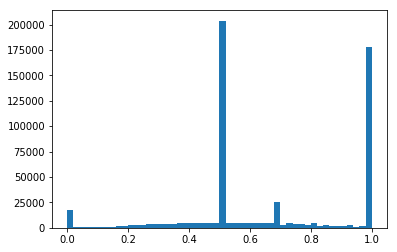

In [8]:
plt.hist(df['trackVolume'], bins=50)

# Check processed mix tracks

In [9]:
num_samples = 1
for i in range(num_samples):
    song_id = find_random_track_w_processed_tracks(df, processed_song_ids)
    mix_audio = get_mix_audio(df, song_id, use_video=True)
    if mix_audio is None:
        continue
    tracks_audio, tracks_volume = get_tracks_audio(df, song_id)
    tracks_audio = unify_audio(tracks_audio, mix_audio)
    est_mix_audio = calc_mix_audio(tracks_audio, tracks_volume)

processed
processed


/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


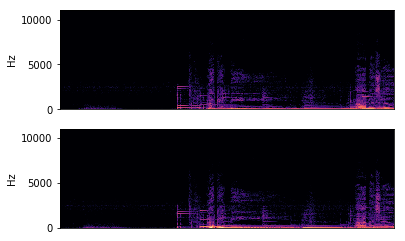

In [24]:
display_stereo_spectrogram(mix_audio, offset=0, size=441000)

Offset: 1024
0.464783 2.79533e-05


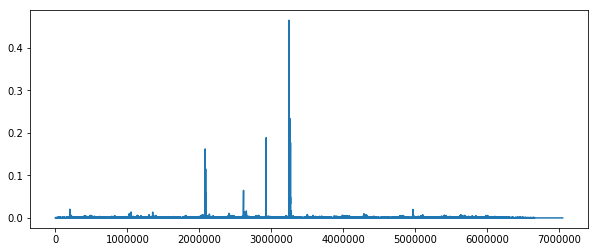

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


24.762 0.0748302


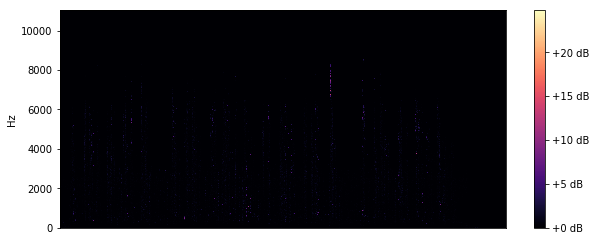

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([[  1.68529809e+00,   6.96420610e-01,   1.13152504e-01, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  9.17748547e+00,   4.92777824e-02,   8.63385201e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  9.01407242e-01,   1.44910240e+00,   2.67499924e-01, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        ..., 
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03]], dtype=float32))

In [25]:
compare_mix(est_mix_audio, mix_audio)

Offset: 0
3.53009 0.223991


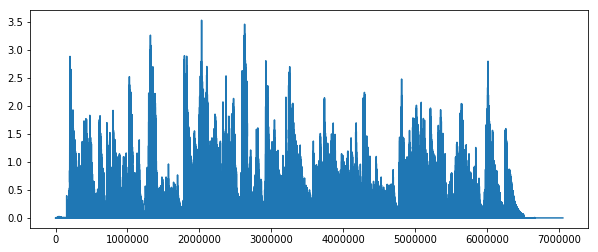

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


56.767 12.7145


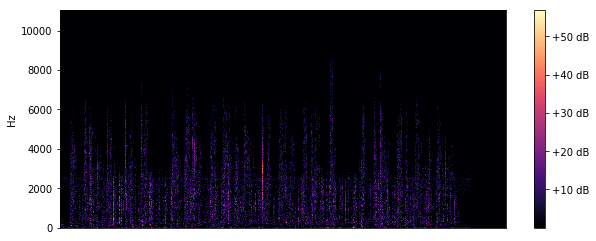

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([[  2.60996628e+01,   3.02722034e+01,   1.25937881e+01, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  4.67934608e+00,   2.68022327e+01,   8.29589748e+00, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  2.17657623e+01,   1.60224342e+01,   1.29160919e+01, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        ..., 
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03],
        [  4.71878052e-03,   4.71878052e-03,   4.71878052e-03, ...,
           4.71878052e-03,   4.71878052e-03,   4.71878052e-03]], dtype=float32))

In [26]:
compare_mix(est_mix_audio, mix_audio, calc_offset=False)

In [27]:
comp_audio = ogg_compress(est_mix_audio, 44100)

Offset: 1024
0.475037 4.85119e-05


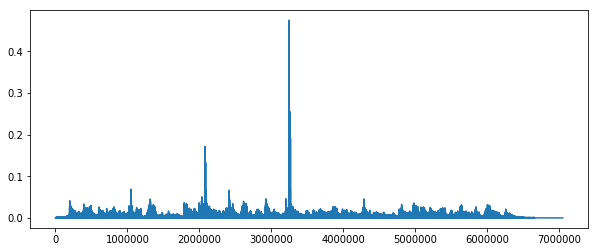

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


37.4922 0.395619


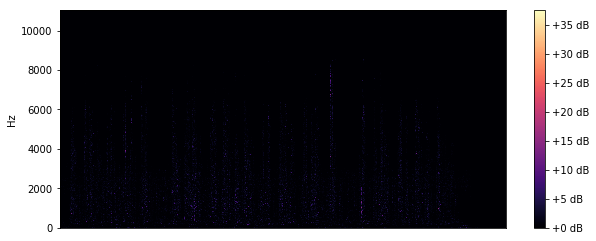

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([[ 1.51073849,  0.56404823,  0.02779341, ...,  0.06467438,
          0.06467438,  0.06467438],
        [ 8.64109516,  0.07089138,  0.06918079, ...,  0.06467438,
          0.06467438,  0.06467438],
        [ 1.01994896,  1.57169819,  0.62669182, ...,  0.06467438,
          0.06467438,  0.06467438],
        ..., 
        [ 0.06467438,  0.06467438,  0.06467438, ...,  0.06467438,
          0.06467438,  0.06467438],
        [ 0.06467438,  0.06467438,  0.06467438, ...,  0.06467438,
          0.06467438,  0.06467438],
        [ 0.06467438,  0.06467438,  0.06467438, ...,  0.06467438,
          0.06467438,  0.06467438]], dtype=float32))

In [28]:
compare_mix(comp_audio, mix_audio, calc_offset=True)

Offset: 1024
Offset: 0
0.463176 0.00188797


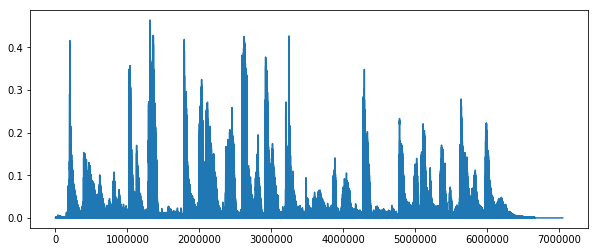

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


31.9271 1.01391


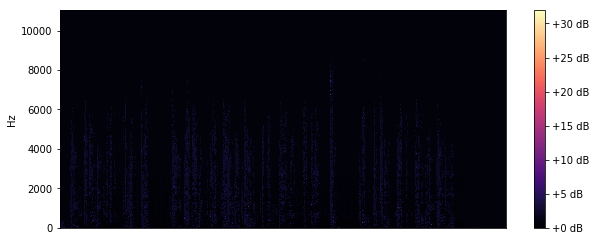

[ 0.96970571  0.75279217]


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([[  2.97520018,   2.0072937 ,   1.41795063, ...,   0.69881821,
           0.69881821,   0.69881821],
        [ 10.24172878,   1.37713647,   1.30855107, ...,   0.69881821,
           0.69881821,   0.69881821],
        [  0.38247967,   0.07043362,   0.71862221, ...,   0.69881821,
           0.69881821,   0.69881821],
        ..., 
        [  0.69881821,   0.69881821,   0.69881821, ...,   0.69881821,
           0.69881821,   0.69881821],
        [  0.69881821,   0.69881821,   0.69881821, ...,   0.69881821,
           0.69881821,   0.69881821],
        [  0.69881821,   0.69881821,   0.69881821, ...,   0.69881821,
           0.69881821,   0.69881821]], dtype=float32))

In [31]:
estimate_mix(est_mix_audio, mix_audio, tracks_audio, calc_offset=True)

# Check unprocessed mix tracks

In [37]:
num_samples = 1
for i in range(num_samples):
    song_id = find_random_track_w_unprocessed_tracks(df, unprocessed_song_ids)
    mix_audio = get_mix_audio(df, song_id, use_video=True)
    if mix_audio is None:
        continue
    tracks_audio, tracks_volume = get_tracks_audio(df, song_id)
    tracks_audio = unify_audio(tracks_audio, mix_audio)
    est_mix_audio = calc_mix_audio(tracks_audio, tracks_volume)

unprocessed
unprocessed


/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


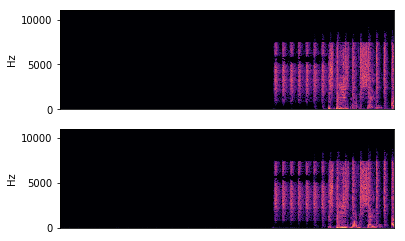

In [38]:
display_stereo_spectrogram(mix_audio, offset=0, size=441000)

Offset: 1024
0.476843 0.0077145


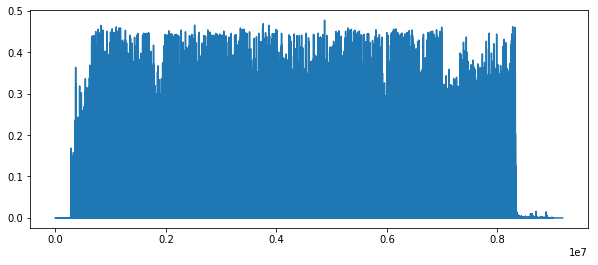

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


44.4567 20.8577


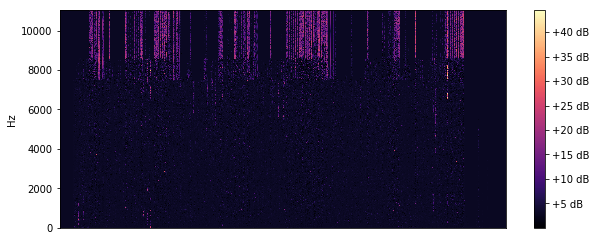

(array([  3.90624991e-05,   7.44629069e-05,   3.29589857e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00], dtype=float32),
 array([[ 2.94594955,  2.88299942,  2.79503632, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  3.11762238,  2.91506958, ...,  2.94594955,
          2.94594955,  2.94594955],
        ..., 
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955]], dtype=float32))

In [39]:
compare_mix(est_mix_audio, mix_audio)

Offset: 0
2.57465 0.147979


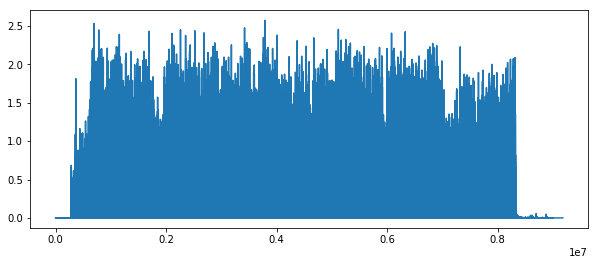

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


67.1028 83.548


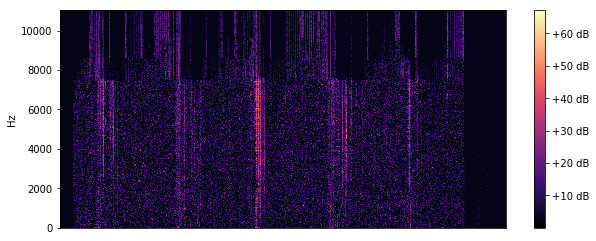

(array([  2.19726571e-05,   3.18603532e-04,   3.29589857e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00], dtype=float32),
 array([[ 2.94594955,  2.94594955,  4.93646622, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  5.40921021,  4.59402847, ...,  2.94594955,
          2.94594955,  2.94594955],
        ..., 
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955],
        [ 2.94594955,  2.94594955,  2.94594955, ...,  2.94594955,
          2.94594955,  2.94594955]], dtype=float32))

In [40]:
compare_mix(est_mix_audio, mix_audio, calc_offset=False)

In [41]:
comp_audio = ogg_compress(est_mix_audio, 44100)

Offset: 1024
0.518677 0.00791745


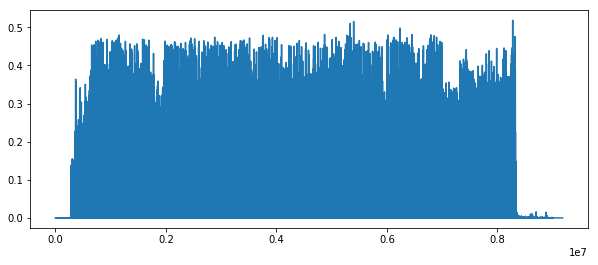

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


43.657 20.8696


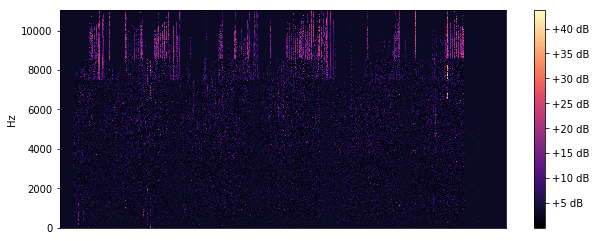

(array([  6.10351562e-05,   1.22070312e-04,   6.10351562e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00], dtype=float32),
 array([[ 3.01750946,  2.95455933,  3.42083549, ...,  3.01750946,
          3.01750946,  3.01750946],
        [ 3.01750946,  3.01750946,  3.01750946, ...,  3.01750946,
          3.01750946,  3.01750946],
        [ 3.01750946,  3.2209549 ,  2.82139587, ...,  3.01750946,
          3.01750946,  3.01750946],
        ..., 
        [ 3.01750946,  3.01750946,  3.01750946, ...,  3.01750946,
          3.01750946,  3.01750946],
        [ 3.01750946,  3.01750946,  3.01750946, ...,  3.01750946,
          3.01750946,  3.01750946],
        [ 3.01750946,  3.01750946,  3.01750946, ...,  3.01750946,
          3.01750946,  3.01750946]], dtype=float32))

In [42]:
compare_mix(comp_audio, mix_audio, calc_offset=True)

In [43]:
estimate_mix(est_mix_audio, mix_audio, tracks_audio, calc_offset=True)

Offset: 1024


KeyboardInterrupt: 

# Calculate on sample

processed
processed
Offset: 1024
0.720874 0.0465188


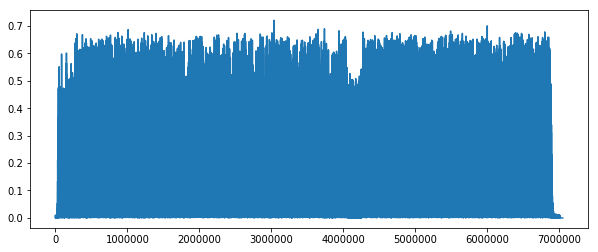

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


49.1099 19.149


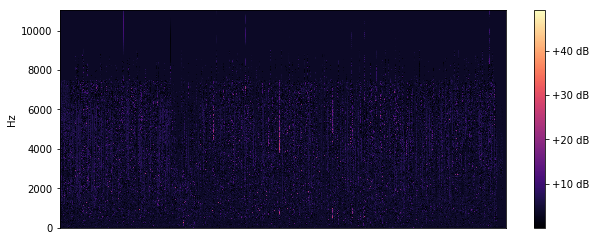

HTTP Error 404: The specified blob does not exist. http://bandhubmediastream.blob.core.windows.net/files/f-2ba2e6fa-bb01-4ed6-bf8f-ee8ec93ca41d.mp4
HTTP Error 404: The specified blob does not exist. http://bandhubmediastream.blob.core.windows.net/files/f-2a6a622a-f6fd-4dbb-bb79-ec62ac88be21.mp4
processed
processed
processed
processed
processed
processed
processed
processed
processed
Offset: 1024
3.69547 0.0125047


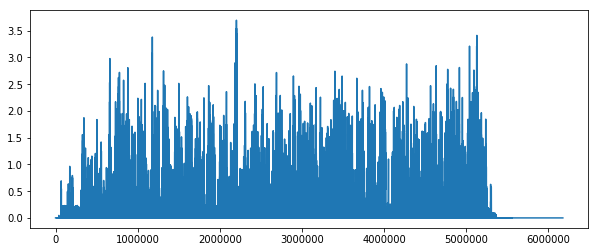

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


56.9566 12.6826


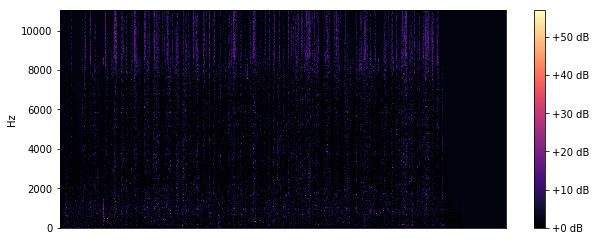

processed
processed
processed
processed
Offset: 1024
0.399988 2.36402e-05


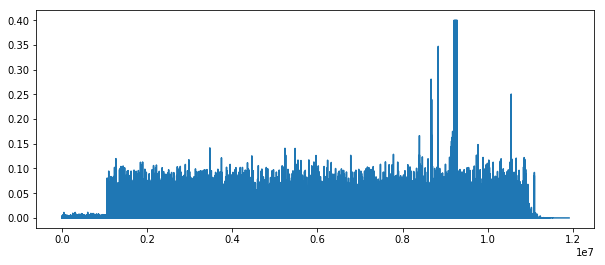

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


33.505 0.854274


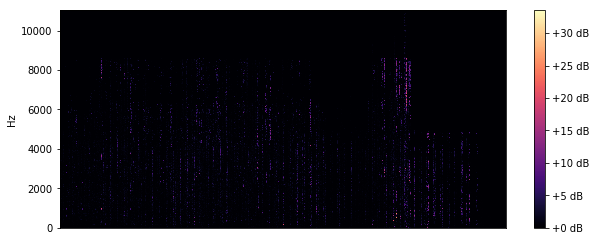

processed
processed
processed
processed
processed
Offset: 1024
3.42958 0.0121875


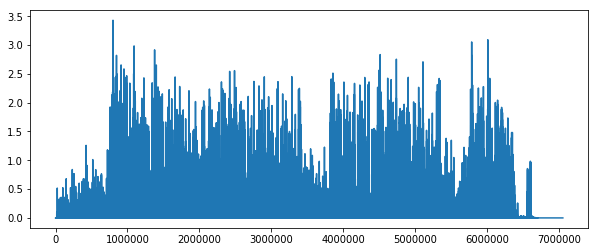

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


48.1598 12.4395


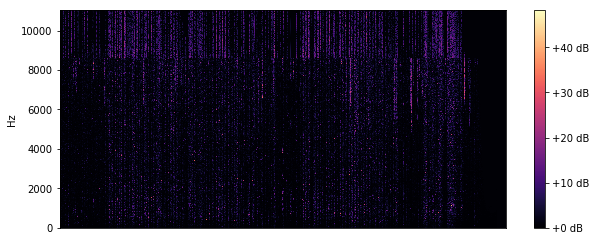

processed
processed
processed
processed
processed
Offset: 1024
2.34672 0.0957262


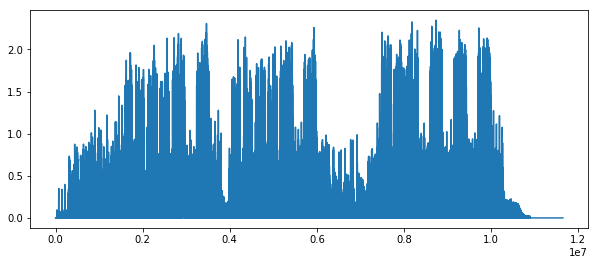

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


56.67 13.7324


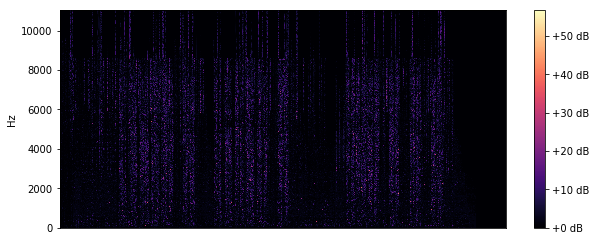

HTTP Error 404: The specified blob does not exist. http://bandhubmediastream.blob.core.windows.net/files/f-a6e45c7d-ae11-4d4c-8534-cb71dad7f1f5.mp4
processed
processed
processed
processed
processed
processed
processed
processed
Offset: 1024
2.6609 0.0626932


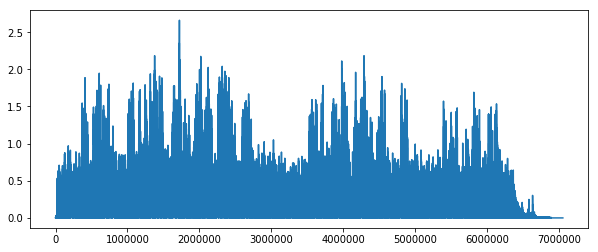

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


53.0914 18.4856


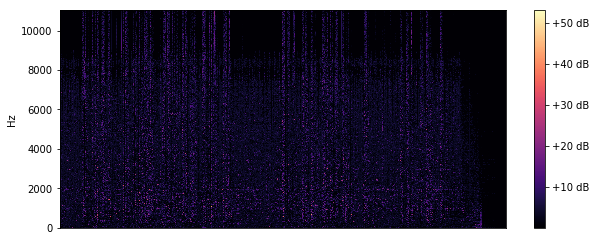

processed
processed
processed
processed
processed
processed
Offset: 1024
0.9858 0.00181857


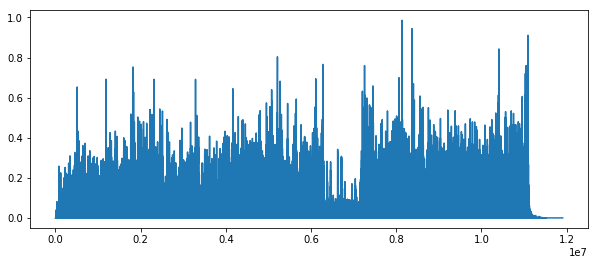

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


44.4617 3.15356


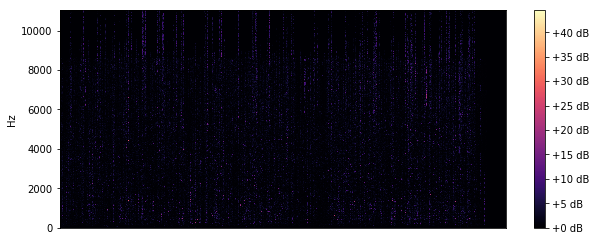

In [44]:
num_samples = 10
for i in range(num_samples):
    song_id = find_random_track_w_processed_tracks(df, processed_song_ids)
    mix_audio = get_mix_audio(df, song_id, use_video=True)
    if mix_audio is None:
        continue
    tracks_audio, tracks_volume = get_tracks_audio(df, song_id)
    tracks_audio = unify_audio(tracks_audio, mix_audio)
    est_mix_audio = calc_mix_audio(tracks_audio, tracks_volume)
    compare_mix(est_mix_audio, mix_audio)

unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
Offset: 1025
1.0202 0.0020257


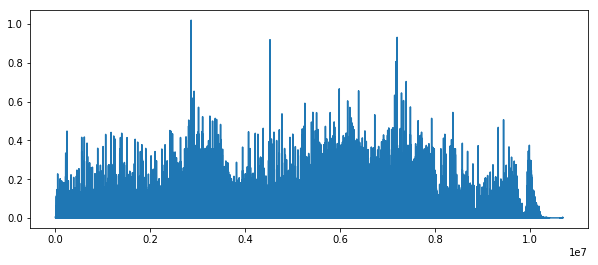

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


44.1987 27.0835


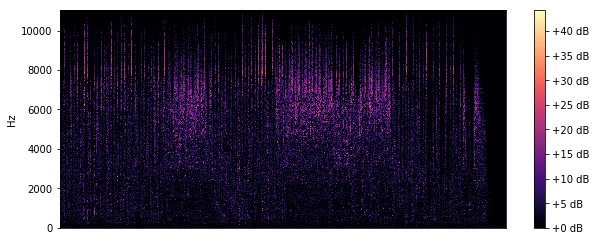

unprocessed
unprocessed
unprocessed
Offset: 1024
2.80698 0.129914


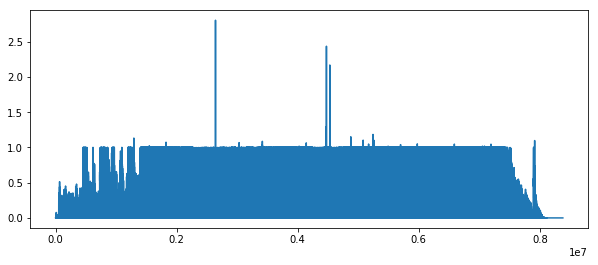

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


46.6085 17.0884


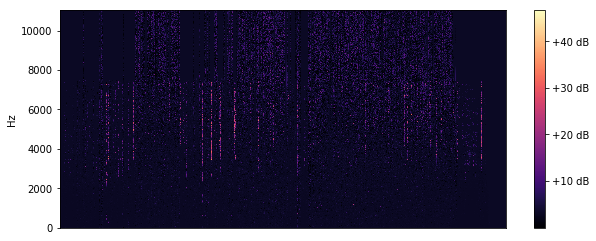

unprocessed
unprocessed
Offset: 1025
0.485168 0.000467783


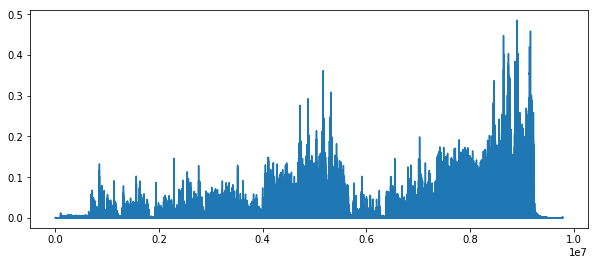

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


38.2037 5.68053


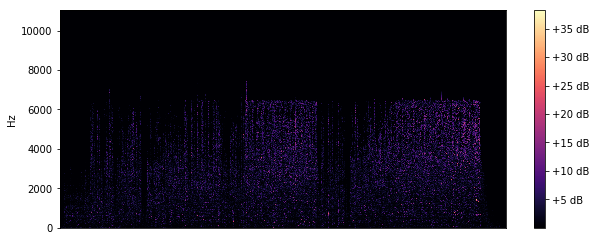

unprocessed
unprocessed
Offset: 1026
0.407013 0.000614748


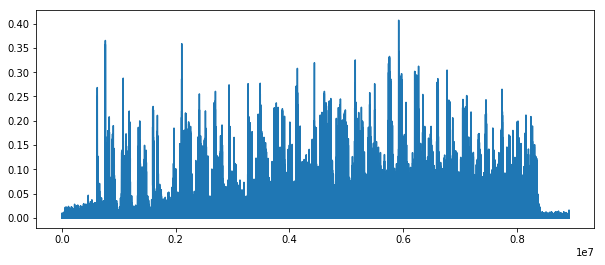

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


61.2093 21.0863


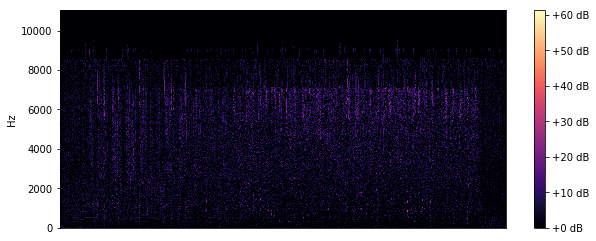

unprocessed
unprocessed
Offset: 1025
0.814502 0.00245125


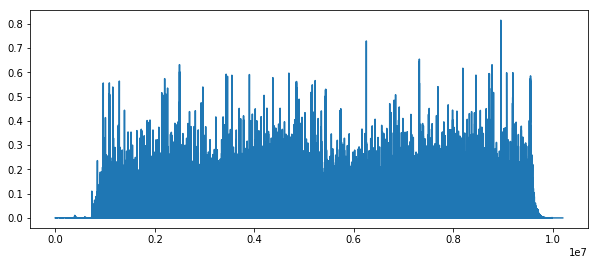

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


49.8145 12.4785


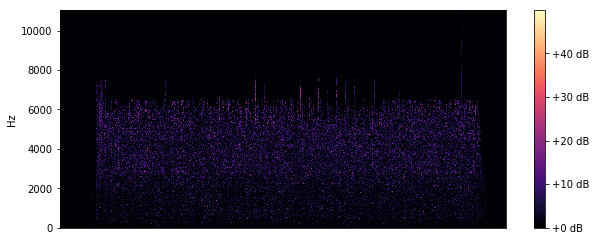

unprocessed
unprocessed
Offset: 0
0.317886 3.05561e-05


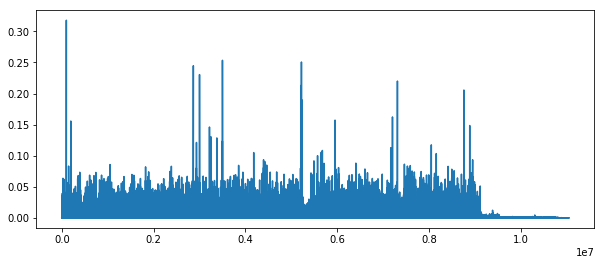

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


29.4043 1.89649


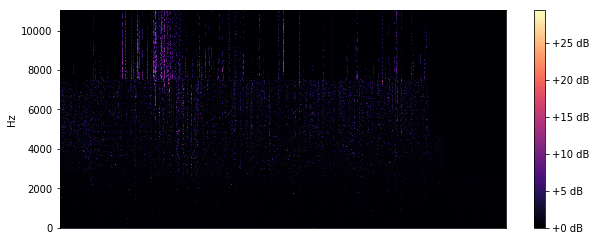

unprocessed
unprocessed
unprocessed
Offset: -45
0.0 0.0


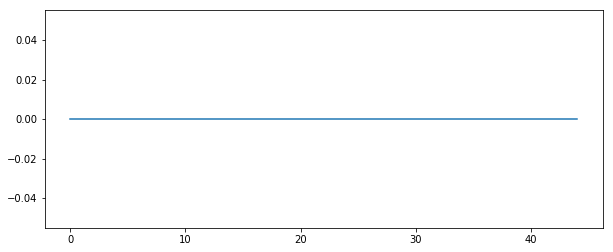

0.0 0.0


/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


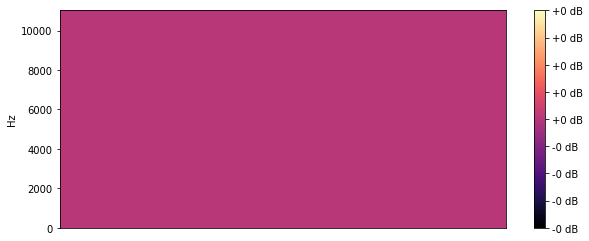

unprocessed
unprocessed
Offset: 1026
0.305298 0.00017826


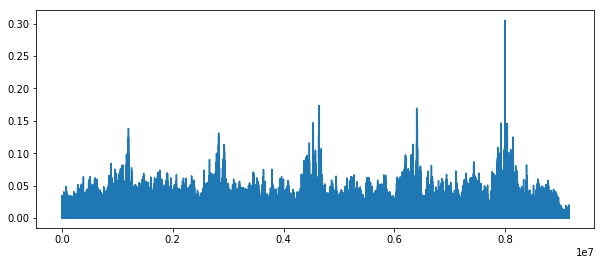

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


34.2844 14.2003


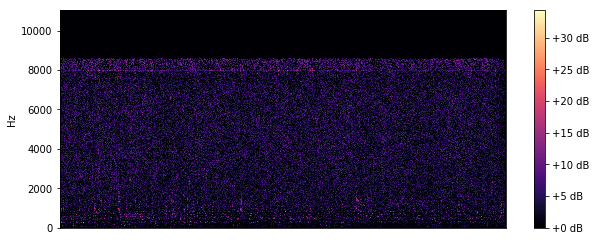

unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
unprocessed
Offset: 1026
1.7708 0.0055019


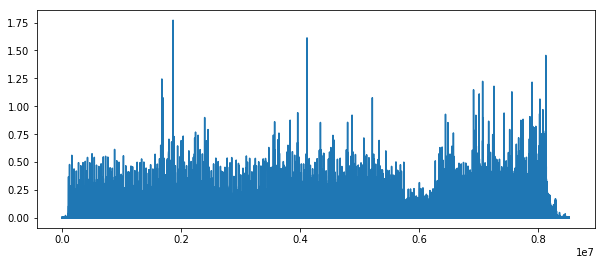

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


42.5331 33.2586


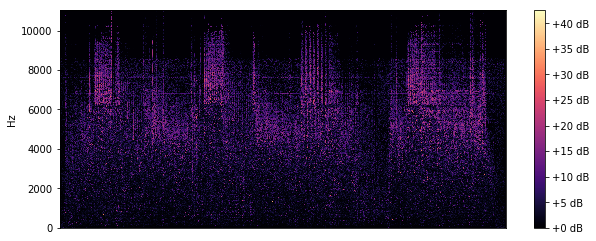

unprocessed
unprocessed
unprocessed
Offset: 1026
1.21504 0.00220867


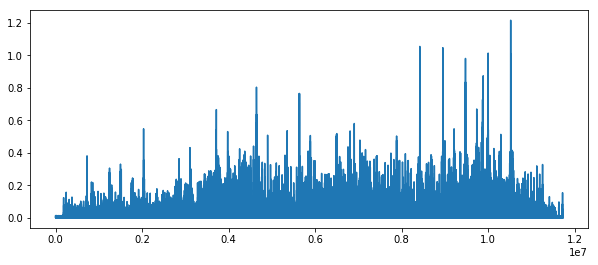

/Users/mcartwright/miniconda2/envs/bandhub/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


48.3566 22.9989


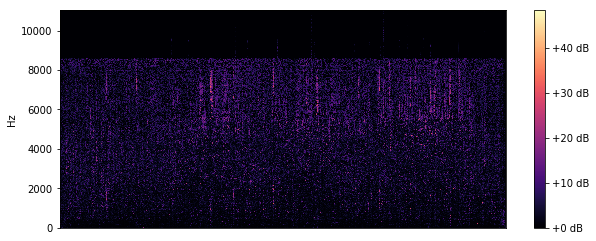

In [58]:
num_samples = 10
for i in range(num_samples):
    song_id = find_random_track_w_unprocessed_tracks(df, unprocessed_song_ids)
    mix_audio = get_mix_audio(df, song_id, use_video=True)
    if mix_audio is None:
        continue
    tracks_audio, tracks_volume = get_tracks_audio(df, song_id)
    tracks_audio = unify_audio(tracks_audio, mix_audio)
    est_mix_audio = calc_mix_audio(tracks_audio, tracks_volume)
    compare_mix(est_mix_audio, mix_audio)